# Analysis of the relationship between nature and cities on multiple cities

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import networkx as nx
import matplotlib as mpl
from matplotlib import pyplot as plt
import folium

In [2]:
gdf = gpd.read_file("../data/cities_analysis/recap_cities.geojson")
print(list(gdf))

['city', 'country', 'population', 'wgraph', 'wres', '#nodes', '#edges', 'area', 'total road length', '#green', 'green area', '#blue', 'blue area', '#cover', 'cover area', '#bikeability=1', '#bikeability=2', '#bikeability=3', '#bikeability=4', '#bikeability=5', '#isolated', '#alongside', '#inbetween', '#surrounded', '#inside', '#none', '#partial', '#full', 'geometry']


The population is coming from the ESA estimation while the area is with the OSM administrative borders, so we can't compare them.

In [3]:
print(f"""{len(gdf[gdf['wres'] == True])} cities with results, cities without a graph are {gdf[gdf['wgraph'] == False]['city'].values}.""")

27 cities with results, cities without a graph are ['Athens' 'Copenhagen' 'Glasgow'].


<AxesSubplot: xlabel='area', ylabel='total road length'>

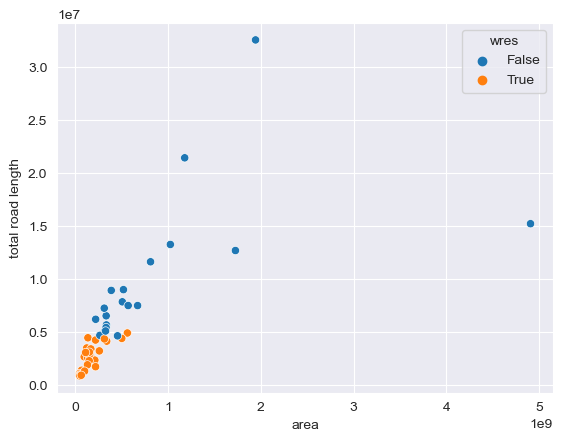

In [4]:
sns.set_style('darkgrid')
sns.scatterplot(data=gdf, x='area', y='total road length', hue='wres')

The total road length compared to the area (being the convex hull of all road edges inside the administrative borders) is somewhat linear, with one big outlier that we will investigate below. We have for now mostly small cities, as they are easier to compute.

In [5]:
biggest_area = gdf[gdf['area'] == max(gdf['area'])]
biggest_area

,city,country,population,wgraph,wres,#nodes,#edges,area,total road length,#green,...,#bikeability=5,#isolated,#alongside,#inbetween,#surrounded,#inside,#none,#partial,#full,geometry
37,Thessaloniki,Greece,813774.992859,True,False,786968.0,818335.0,4.905480e+09,15256362.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((23.00486 40.35023, 22.88903 40.37393..."


In [6]:
centroid = list(biggest_area.geometry.values[0].centroid.coords[:][0])
centroid.reverse()
m = folium.Map(location = centroid, zoom_start=10)
folium.GeoJson(data=biggest_area.geometry).add_to(m)
m

As we can see, this outlier is explanable by the fact that the administrative border found in OSM are not similar as the "natural city borders", including lakes, moutains, forests...

5 most bikeable cities: ['Antwerp' 'Dusseldorf' 'Amsterdam' 'Rotterdam [The Hague]' 'Paris']
5 least bikeable cities: ['Naples' 'Liverpool' 'Porto' 'Belgrade' 'Dublin']
5 cities with the most number of bike path: ['Dusseldorf' 'Amsterdam' 'Antwerp' 'Rotterdam [The Hague]' 'Paris']
5 cities with the least number of bike path: ['Porto' 'Naples' 'Tirana' 'Lille' 'Bilbao']


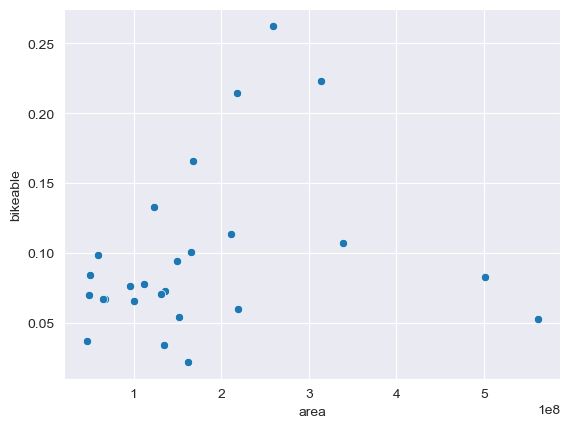

In [7]:
sns.set_style('darkgrid')
gdf['bikeable'] = gdf['#bikeability=1']/gdf['#edges']
sns.scatterplot(data=gdf, x='area', y='bikeable')
print(f"5 most bikeable cities: {gdf.nlargest(5, 'bikeable')['city'].values}")
print(f"5 least bikeable cities: {gdf.nsmallest(5, 'bikeable')['city'].values}")
print(f"5 cities with the most number of bike path: {gdf.nlargest(5, '#bikeability=1')['city'].values}")
print(f"5 cities with the least number of bike path: {gdf.nsmallest(5, '#bikeability=1')['city'].values}")

Mean bikeability of 0.096, standard deviation of 0.057


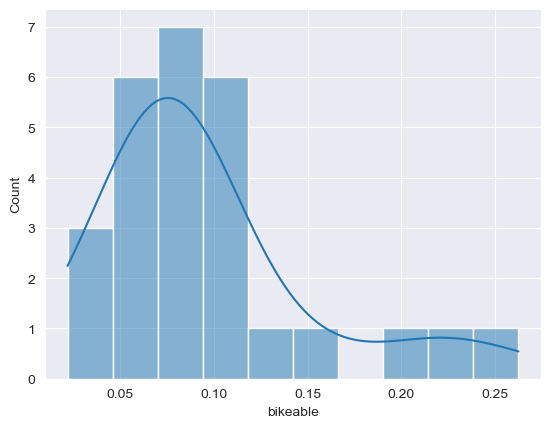

In [8]:
sns.histplot(data=gdf, x='bikeable', kde=True, bins=10)
bikeable_val = [val for val in gdf['bikeable'].values if str(val) != 'nan']
print(f"Mean bikeability of {round(np.mean(bikeable_val), 3)}, standard deviation of {round(np.std(bikeable_val), 4)}")

We could argue that a road is not only bikeable if it's a bicycle path, discriminated by the presence of cars and pedestrians with physical obstacles. Doing so we need to make a difference between a bicycle path and paintings indicating that a road is made for bicycle, adding arbitrary weights to the definition.

5 most bikeable (extended) cities: ['Antwerp' 'Dusseldorf' 'Amsterdam' 'Paris' 'Rotterdam [The Hague]']
5 least bikeable (extended) cities: ['Naples' 'Belgrade' 'Málaga' 'Porto' 'Barcelona']


<AxesSubplot: xlabel='area', ylabel='bikeable_extended'>

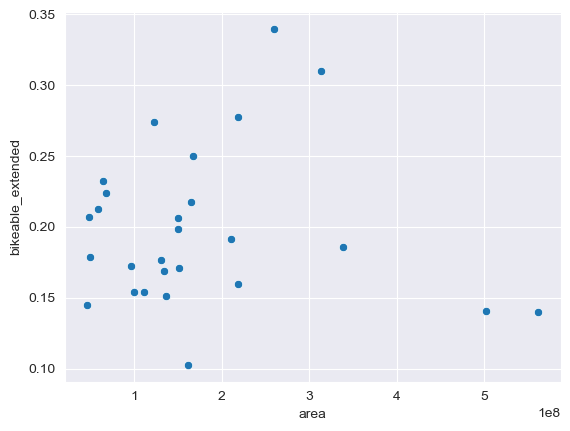

In [9]:
gdf['bikeable_extended'] = (gdf['#bikeability=1'] + gdf['#bikeability=2']/2 + gdf['#bikeability=3']/4) / gdf['#edges']
print(f"5 most bikeable (extended) cities: {gdf.nlargest(5, 'bikeable_extended')['city'].values}")
print(f"5 least bikeable (extended) cities: {gdf.nsmallest(5, 'bikeable_extended')['city'].values}")
sns.scatterplot(data=gdf, x='area', y='bikeable_extended')

Mean extended bikeability of 0.198, standard deviation of 0.0543
5 cities with the largest delta between definition of bikeabily are ['Tirana' 'Lyon' 'Paris' 'Lille' 'Liverpool']


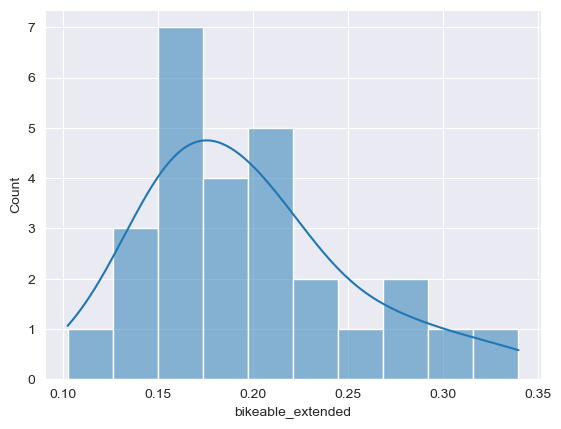

In [10]:
sns.histplot(data=gdf, x='bikeable_extended', kde=True, bins=10)
bikeable_val = [val for val in gdf['bikeable_extended'].values if str(val) != 'nan']
print(f"Mean extended bikeability of {round(np.mean(bikeable_val), 3)}, standard deviation of {round(np.std(bikeable_val), 4)}")
gdf['delta_bikeable'] = np.abs(gdf['bikeable_extended'] - gdf['bikeable'])
print(f"5 cities with the largest delta between definition of bikeabily are {gdf.nlargest(5, 'delta_bikeable')['city'].values}")

In [11]:
print(f"5 others most bikeable (extended) cities: {gdf.nlargest(10, 'bikeable_extended')['city'].values[5:]}")
paris_delta = gdf[gdf['city'] == 'Paris']['delta_bikeable'].values[0]
paris_bikeable = gdf[gdf['city'] == 'Paris']['bikeable'].values[0]
tirana_delta = gdf[gdf['city'] == 'Tirana']['delta_bikeable'].values[0]
tirana_bikeable = gdf[gdf['city'] == 'Tirana']['bikeable'].values[0]
print(
    f"""Delta for Paris is {paris_delta} or a {round(100 * paris_delta/paris_bikeable)}% increase,
    for Tirana is {tirana_delta} or a {round(100 * tirana_delta/tirana_bikeable)}% increase""")

5 others most bikeable (extended) cities: ['Tirana' 'Lyon' 'Manchester' 'Brussels' 'Lille']
Delta for Paris is 0.14126598436835153 or a 106% increase,
    for Tirana is 0.16498636191002314 or a 245% increase


Extending the definition with those arbitrary weights doesn't lead to drastic changes for most cities, the distribution is shifted towards a higher mean and there are more intermediate cities between the three highly bikeable cities that are Antwerp, Dusseldorf, and Amsterdam. Interesting ones are Paris and Tirana : Paris was really behind the other as the 5th highly bikeable cities before but with the 3rd largest delta is now the 4th highest bikeable, really close to the 3rd. 

Tirana is the 6th city in extended bikeability but the 3rd worse in number of bike path !

One issue with the extended definition is that we include streets tagged as "residential" to be at level 3. It makes sense but depending on the community a "residential" street can be a 50km/h street, with varying traffic or a calm 30km/h street. On the opposite, streets that are not residential or with a maximum speed of 30km/h are at level 4, the worst level where streets are still legally bikeable but without any features for a safe and relaxed trip on a bike.

5 cities with high bikeability of level 3: ['Tirana' 'Dublin' 'Palermo' 'Turin' 'Liverpool']
5 cities with low bikeability of level 3: ['Zurich' 'Barcelona' 'Málaga' 'Dusseldorf' 'Amsterdam']


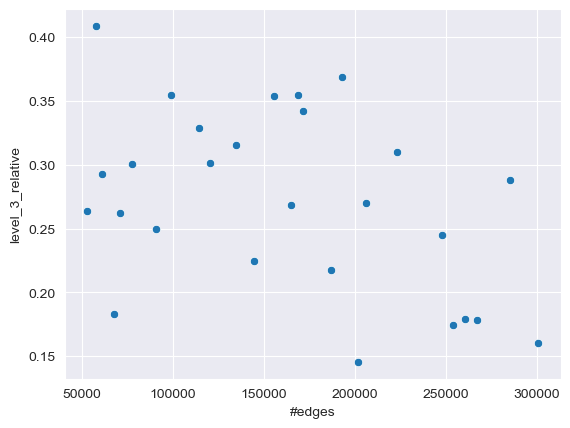

In [12]:
gdf['level_3_relative'] = gdf['#bikeability=3']/gdf['#edges']
sns.scatterplot(data=gdf, x='#edges', y='level_3_relative')
print(f"5 cities with high bikeability of level 3: {gdf.nlargest(5, 'level_3_relative')['city'].values}")
print(f"5 cities with low bikeability of level 3: {gdf.nsmallest(5, 'level_3_relative')['city'].values}")

Tirana, Lille, and Liverpool have high delta of bikeability and high number of level 3 streets. Tirana and Lyon have quite high extended bikeability because of this. Amsterdam and Dusseldorf have a low number of level 3 streets but they are already highly bikeable, so it's likely that this is because they are already so many streets with a bikeability level of 1 or 2. Barcelona and Málaga have a low number of level 3 streets and are becoming the 3rd and 5th cities with the worst extended bikeability, because they have a lot of streets that are not tagged as residential or without a maximum speed < 30km/h so at level 4. Zurich is special because if we look at the city graph, most streets are at level 5 so it should be illegal or impossible to bike on them !

To get more informations, we should inspect if the level 3 comes from being residential or at a maximum speed < 30km/h.

Another issue is that depending on OSM precision and local standards, protected bicycle network can be tagged on the street, or be a completely independent, parallel streets ! It's obvious in Amsterdam, where most bicycle corridors of level 1 are running parallel to level 4 streets. This can reduce the bikeability of the city, as the number of edges increases with level 4 edges.

If we want to compare by countries, we need to take into account that we don't compare the same number of cities for each country, thus changing the standard deviation.

In [13]:
num = []
for country in set(gdf['country'].values):
    num.append([country, len(gdf[(gdf['country'] == country) & (gdf['wres'] == True)])])
num = pd.DataFrame(num, columns=['country', '#cities'])
num.sort_values('#cities', inplace=True, ignore_index=True)
num[num['#cities'] > 0]

,country,#cities
7,Serbia,1
8,Ireland,1
9,Switzerland,1
10,Germany,1
11,Albania,1
12,Portugal,2
13,Belgium,2
14,Netherlands,2
15,Italy,3
16,United Kingdom,3


In [14]:
ranking = []
for country in set(gdf['country'].values):
    val = gdf[gdf['country'] == country]['bikeable'].values
    val = val[~np.isnan(val)]
    if len(val) > 0:
        ranking.append([country, np.mean(val)])
ranking = pd.DataFrame(ranking, columns=['country', 'mean bikeability'])
ranking.sort_values('mean bikeability', inplace=True, ignore_index=True)
ranking

,country,mean bikeability
0,Serbia,0.052505
1,Ireland,0.053875
2,Portugal,0.056736
3,Italy,0.058502
4,Albania,0.067310
5,United Kingdom,0.068533
6,Switzerland,0.077744
7,France,0.088590
8,Spain,0.089491
9,Belgium,0.180354


In [15]:
ranking = []
for country in set(gdf['country'].values):
    val = gdf[gdf['country'] == country]['bikeable_extended'].values
    val = val[~np.isnan(val)]
    if len(val) > 0:
        ranking.append([country, np.mean(val)])
ranking = pd.DataFrame(ranking, columns=['country', 'mean bikeability (extended)'])
ranking.sort_values('mean bikeability (extended)', inplace=True, ignore_index=True)
ranking

,country,mean bikeability (extended)
0,Serbia,0.139989
1,Switzerland,0.154184
2,Italy,0.156188
3,Portugal,0.158383
4,Ireland,0.170744
5,Spain,0.172005
6,United Kingdom,0.187584
7,France,0.208932
8,Albania,0.232296
9,Netherlands,0.263893


Albania is somewhat of an outlier because there is only one city with high bikeability

We don't have results for all cities but we can already see that Benelux and the surroundings are trusting the higher rankings, whil Southern/Eastern Europe countries are more on the lower rankings. Germany and Albania as countries are outlier because there is only one city investigated so far.

5 most natural cities: ['Zurich' 'Valencia' 'Palermo' 'Amsterdam' 'Bilbao']
5 least natural cities: ['Paris' 'Lille' 'Tirana' 'Lyon' 'Manchester']
5 most coverage cities: ['Bilbao' 'Zurich' 'Dusseldorf' 'Lyon' 'Manchester']
5 least coverage cities: ['Valencia' 'Seville' 'Málaga' 'Porto' 'Lisbon']


<AxesSubplot: xlabel='coverage', ylabel='natural'>

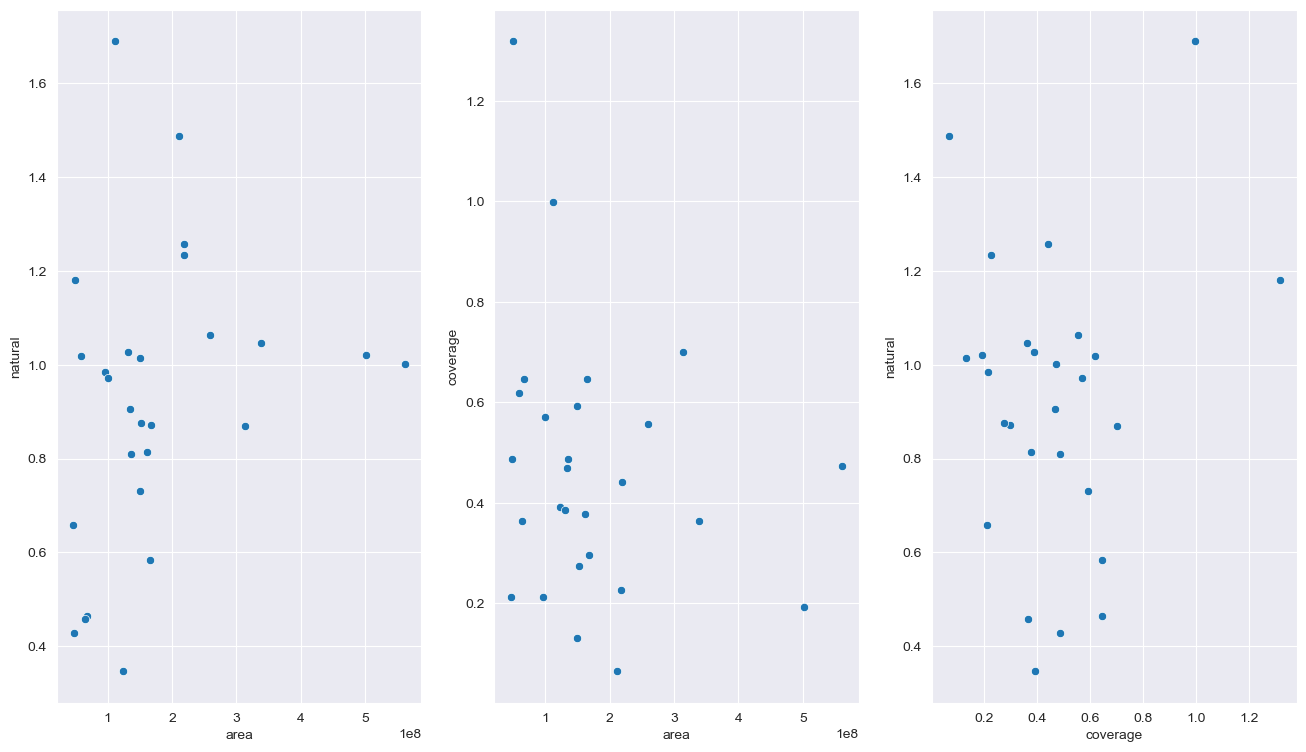

In [16]:
gdf['natural'] = (gdf['green area'] + gdf['blue area']) / gdf['area']
gdf['coverage'] = gdf['cover area'] / gdf['area']
print(f"5 most natural cities: {gdf.nlargest(5, 'natural')['city'].values}")
print(f"5 least natural cities: {gdf.nsmallest(5, 'natural')['city'].values}")
print(f"5 most coverage cities: {gdf.nlargest(5, 'coverage')['city'].values}")
print(f"5 least coverage cities: {gdf.nsmallest(5, 'coverage')['city'].values}")
fig, axs = plt.subplots(1, 3, figsize=(16, 9))
sns.scatterplot(data=gdf, x='area', y='natural', ax=axs[0])
sns.scatterplot(data=gdf, x='area', y='coverage', ax=axs[1])
sns.scatterplot(data=gdf, x='coverage', y='natural', ax=axs[2])

There are a couple of issues with these definitions : green and blue areas are the ones with an intersection with the bounding box of the city, so if the geometry of the city is curved, and if the city is near a huge natural place that only slightly intersect with the city, this will cause biases. Also, the city here is the administrative city, so if there are some lonely roads way outside of the city, it can add a lot of nature. 

Still, we can see that Amsterdam is well surrounded by nature and Dusseldorf is well covered with tree canopies, and they are also the most bikeable cities. Paris is very bikeable but without a lot of nature inside the city. Porto is not bikeable and there is no coverage. Zurich and Bilbao are the only cities that are highly covered and natural at the same time.

The distribution of coverage is less spreaded than the coverage of nature.

We visualize their results below and their graphs.

Another thing to note is that on 5 least natural cities, 3 of them are French. This is partially explained because the administrative boundaries of cities in France are strict: Paris and Lyon for instance have much larger urban areas than the actual city limits.
The 5 least coverage cities are all in the Iberian Peninsula. This is probably because the climate is so hot that most natural areas don't have a tree canopy but drier, smaller plants.

<AxesSubplot: xlabel='bikeable', ylabel='coverage'>

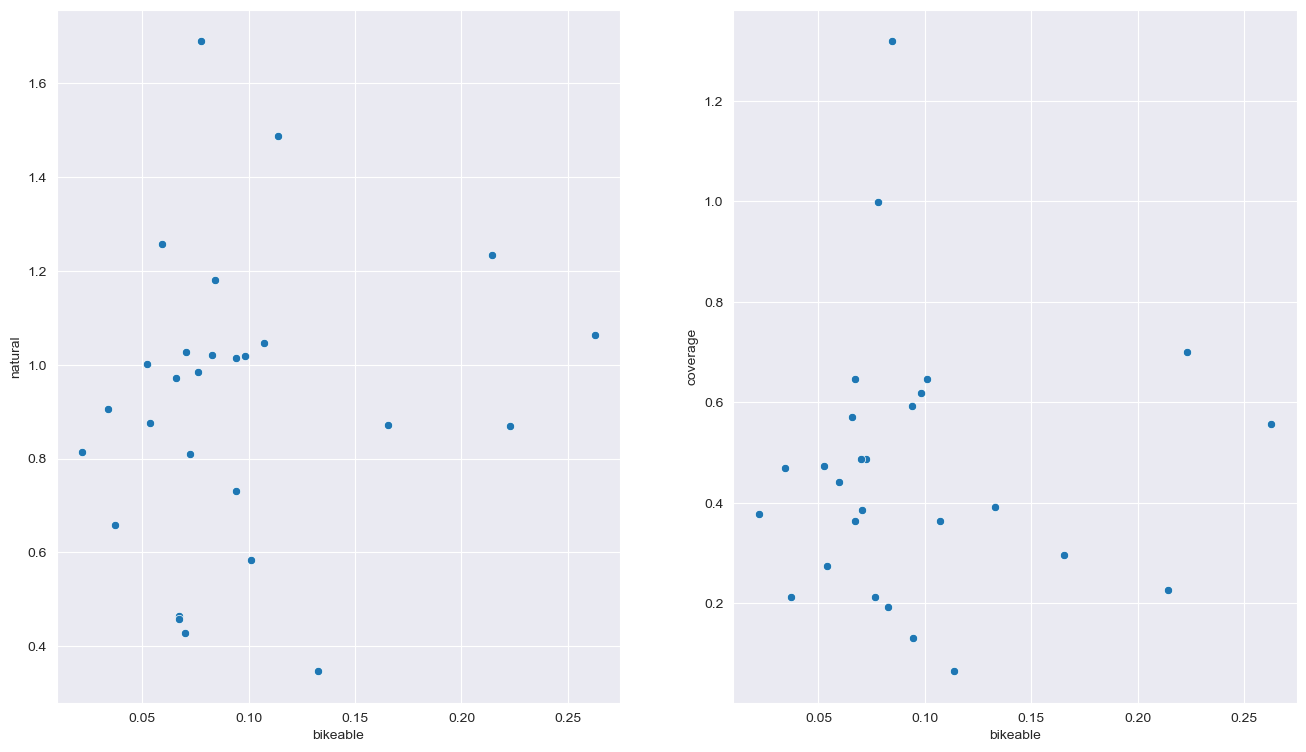

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
sns.scatterplot(data=gdf, x='bikeable', y='natural', ax=axs[0])
sns.scatterplot(data=gdf, x='bikeable', y='coverage', ax=axs[1])

In [18]:
gdf['covered'] = (gdf['#full'] + gdf['#partial']/2) / gdf['#edges']
gdf['natural_roads'] = (gdf['#inside'] +  gdf['#surrounded']/2 + gdf['#inbetween']/3 + gdf['#alongside']/4) / gdf['#edges']
print(f"5 cities with the most roads close to nature: {gdf.nlargest(5, 'covered')['city'].values}")
print(f"5 cities with the least roads close to nature: {gdf.nsmallest(5, 'covered')['city'].values}")
print(f"5 cities with the most covered roads: {gdf.nlargest(5, 'natural')['city'].values}")
print(f"5 cities with the least covered roads: {gdf.nsmallest(5, 'natural')['city'].values}")

5 cities with the most roads close to nature: ['Dusseldorf' 'Zurich' 'Manchester' 'Paris' 'Newcastle upon Tyne']
5 cities with the least roads close to nature: ['Seville' 'Valencia' 'Tirana' 'Málaga' 'Porto']
5 cities with the most covered roads: ['Zurich' 'Valencia' 'Palermo' 'Amsterdam' 'Bilbao']
5 cities with the least covered roads: ['Paris' 'Lille' 'Tirana' 'Lyon' 'Manchester']


Comparing not the amount of nature or coverage in the area of the city relative to the size of the city but the amount of roads close to nature relative to the total amount of roads make more sense in our mobility. Paris is quite intriguing in that sense, being the 4th city with most roads close to nature and the 5th worst city in amount of natural areas. If we look at the graph, this makes more sense as the definition of Paris is restricted to inside the periphery which is very urbanized and dense and full of concrete, but it also take into account two forests close : Bois de Boulogne and Bois de Vincennes, that are huge natural areas with a lot of roads inside nature.

In [19]:
city_selected = ['Amsterdam', 'Dusseldorf', 'Paris', 'Porto']
gdf[gdf['city'].isin(city_selected)]

,city,country,population,wgraph,wres,#nodes,#edges,area,total road length,#green,...,#full,geometry,bikeable,bikeable_extended,delta_bikeable,level_3_relative,natural,coverage,covered,natural_roads
0,Paris,France,9.711652e+06,True,True,197305.0,223265.0,123399112.0,3532116.0,8659.0,...,13445.0,"POLYGON ((2.34429 48.81571, 2.33367 48.81677, ...",0.132739,0.274005,0.141266,0.310138,0.346554,0.392479,0.217802,0.280886
26,Amsterdam,Netherlands,1.128715e+06,True,True,230745.0,260576.0,218374295.0,4280354.0,15599.0,...,12314.0,"POLYGON ((4.91020 52.31828, 4.85750 52.32147, ...",0.214210,0.277445,0.063235,0.179149,1.233484,0.227018,0.162874,0.417274
29,Porto,Portugal,9.982835e+05,True,True,64908.0,70800.0,46729000.0,1119917.0,7721.0,...,2642.0,"POLYGON ((-8.61524 41.13998, -8.61569 41.14000...",0.037076,0.144573,0.107496,0.262302,0.658886,0.211728,0.097076,0.304616
43,Dusseldorf,Germany,7.440198e+05,True,True,244500.0,267080.0,313774978.0,4389263.0,17363.0,...,19627.0,"POLYGON ((6.90036 51.12489, 6.85822 51.12749, ...",0.223012,0.309960,0.086948,0.177992,0.869933,0.700124,0.301803,0.349330


Main directions:
- Use dask-geopandas dataframe and shapely 2.0 for faster python workflow and work with bigger cities
- Use more cities in same amount of countries to see if we can compare countries/regions
- Compare UCDB boundaries and OSM boundaries, use difference between two to estimate population and use it as axis
- Dig deeper on interesting cities:
    - Why Zurich have so much nature and so much level 5 bikeability
    - Look at Barcelona streets tag and why so much level 4
    - Take Amsterdam and Dusseldorf as example of lot of nature with lot of bikeability
    - Take Paris as example of lot of bikeability without lot of nature
    - Take Porto as example of no bikeability and no nature
- Use dual graph to find relationship between corridors and nature/coverage/bikeability
- Find measure like circuity but to see the difference not only between bikeable and not bikeable path but also nature
- See if there is sometimes a relationship between bikeability and proximity to nature/cover